# RNN to forecast a sine wave
Build an RNN to learn what a sine wave looks like, then attempt to predict future values

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


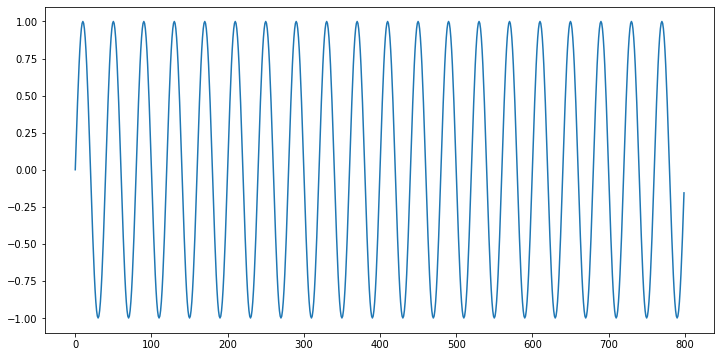

In [5]:
# Build sine wave data
x = torch.linspace(0,799,800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,6))
plt.plot(x,y)

In [10]:
# Create train set and test set
# We don't do a random train/test split since we are trying to forecast into the future!
test_size = 40
total_size = len(x)

train = y[:-test_size]
test = y[-test_size:]

# Build training sequences (batches)
# These training sequences will have a set of training values along with the next value in the sequence (a "label")
def input_data(train_seq, window_size):
    out = []  # [([0,1,2,3], [4]), ...]
    L = len(train_seq)
    for i in range(L-window_size):
        window = train_seq[i:i+window_size]
        label = train_seq[i+window_size:i+window_size+1]  # Just predict 1 point into the future
        out.append((window,label))
    return out

# Batch training data
window_size=40
train_data = input_data(train, window_size)

# Check the training data
print(train_data[0])

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]), tensor([1.4480e-05]))


### Build LSTM model

In [28]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        """
        input_size -> 1 y-val per timestamp (can feed in multiple time-series' as inputs)
        hidden_size -> how many neurons in the LSTM layer ?
        output_size -> 1 prediction
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        # Initialize the hidden state and cell state that go into the LSTM neurons
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)  # reshape sequence in case we end up playing with batch size. This gives us 1 column per batch
        pred = self.linear(lstm_out.view(len(seq),-1))  # reshape output of LSTM in case we end up playing with batch size (reshapes lstm_out to be columnar)
        return pred[-1]  # pred returns [1,2,3,4], but we only care about the predicted values of "4", so grab the last element

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # SGD converges faster than adam in this case

model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [29]:
# How many parameters do we have?
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


### Train model
- As we train, create a forecast object that predicts the values of the sine wave between 760 and 800. As we train, we would expect this forecast to get more accurate. We can then pass the final forecast values back into the model and continue to forecast into the unknown!
- With "real data", we would not have values to compare predictions with!

Epoch: 0 | Loss: 0.08461075276136398
Performance on test range: 0.5878419876098633


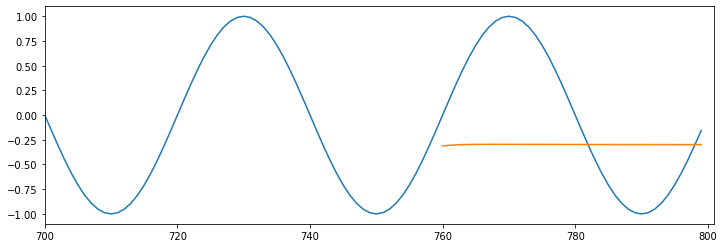

Epoch: 1 | Loss: 0.03540628403425217
Performance on test range: 0.475965678691864


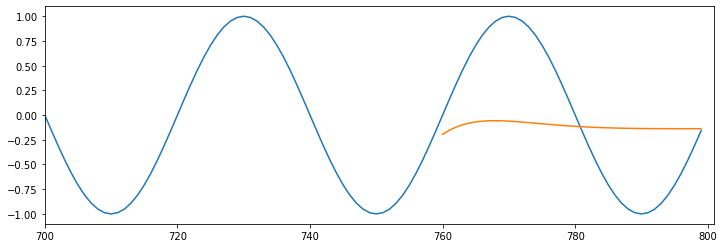

Epoch: 2 | Loss: 0.0025756775867193937
Performance on test range: 0.12342438846826553


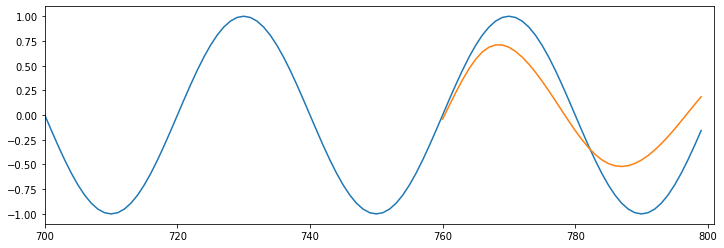

Epoch: 3 | Loss: 0.00020892909378744662
Performance on test range: 0.012315632775425911


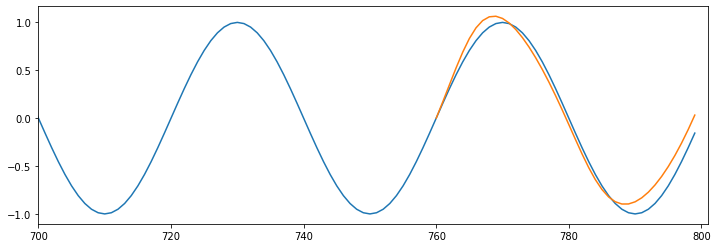

Epoch: 4 | Loss: 0.00017027734429575503
Performance on test range: 0.008193450048565865


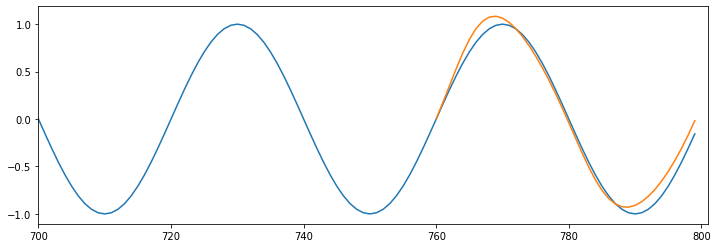

Epoch: 5 | Loss: 0.0001780366146704182
Performance on test range: 0.006815475877374411


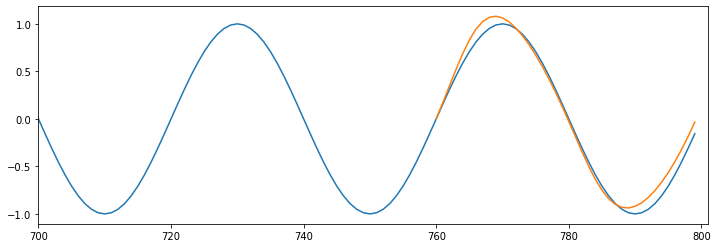

Epoch: 6 | Loss: 0.00018156360602006316
Performance on test range: 0.005801250226795673


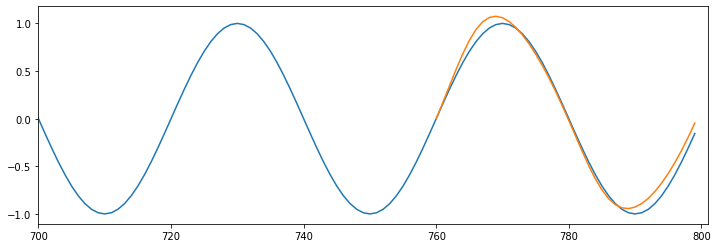

Epoch: 7 | Loss: 0.0001805370266083628
Performance on test range: 0.005005803890526295


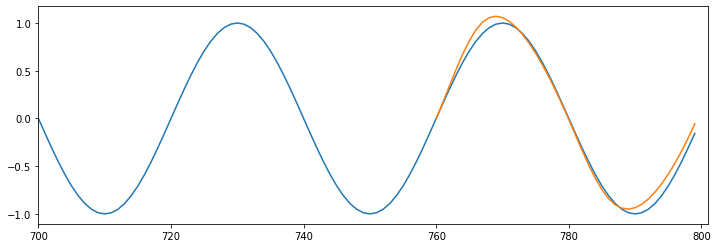

Epoch: 8 | Loss: 0.0001763775071594864
Performance on test range: 0.004373384639620781


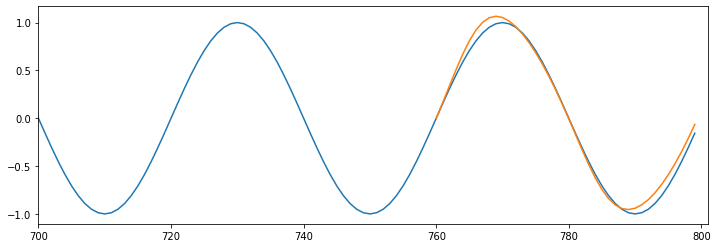

Epoch: 9 | Loss: 0.00017021979147102684
Performance on test range: 0.0038649197667837143


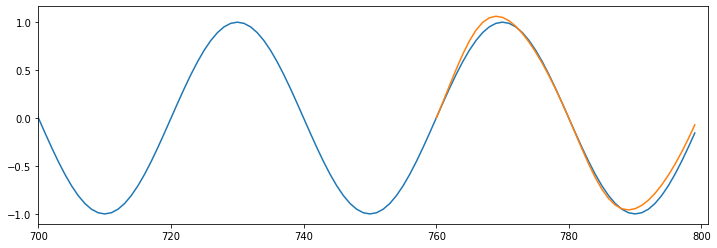

In [30]:
epochs = 10
future = 40

for i in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()  # maximize
        # Reset the params for the hidden states (hidden state and cell state))
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        # Calc prediction
        y_pred = model(seq)
        # Update weights
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {i} | Loss: {loss.item()}')

    # Grab last window in training set
    preds = list(train[-window_size:])
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        # Don't update w&b
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
    # Compare predictions to test set
    loss = criterion(torch.tensor(preds[-window_size:]), test)
    print(f'Performance on test range: {loss}')

    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.plot(y.numpy())
    plt.plot(range(760,800), preds[window_size:])
    plt.show()

### Train on all data
Then forecast into the unknown future!

In [34]:
epochs = 15
window_size = 40
future = 40

all_data = input_data(y, window_size)

import time
start = time.time()

for i in range(epochs):
    for seq,y_train in all_data:
        # Look for maxima
        optimizer.zero_grad()
        # Re-instantiate hidden and cell state
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        # Generate prediction
        y_pred = model(seq)
        # Calc loss and update w&b
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    # Check to see how the model is performing
    print(f'Epoch: {i+1} | Loss: {loss.item()}')

elapsed = round(time.time() - start,2)
print(f'All done! Total time taken was {elapsed} seconds.')

Epoch: 1 | Loss: 0.00016244813741650432
Epoch: 2 | Loss: 0.00015409760817419738
Epoch: 3 | Loss: 0.0001456082973163575
Epoch: 4 | Loss: 0.00013727566692978144
Epoch: 5 | Loss: 0.0001292851084144786
Epoch: 6 | Loss: 0.00012174185394542292
Epoch: 7 | Loss: 0.00011469965102151036
Epoch: 8 | Loss: 0.00010816923895617947
Epoch: 9 | Loss: 0.00010214353096671402
Epoch: 10 | Loss: 9.660366777097806e-05
Epoch: 11 | Loss: 9.151850827038288e-05
Epoch: 12 | Loss: 8.685750799486414e-05
Epoch: 13 | Loss: 8.258352318080142e-05
Epoch: 14 | Loss: 7.865981751820073e-05
Epoch: 15 | Loss: 7.505761459469795e-05
All done! Total time taken was 160.26 seconds.


### Forecast unknown future values
Use the model to predict how the sine wave behaves beyond x=800

In [37]:
preds = list(y[-window_size:])

for i in range(future):
    # Sliding scale of 40 points used to predict future 1 point
    seq = torch.FloatTensor(preds[-window_size:])
    # Don't update model weights
    with torch.no_grad():
        # Reset hidden and cell state
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        # Predict next point using previous 40 points
        # As we go past i=0, we will begin to predict with predicted values!
        preds.append(model(seq).item())

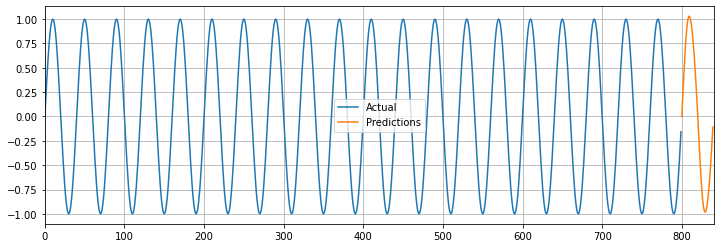

In [42]:
plt.figure(figsize=(12,4))
plt.xlim(0,841)
plt.plot(y.numpy(), label='Actual')
plt.plot(range(800,800+future), preds[window_size:], label='Predictions')
plt.grid(True)
plt.legend()
plt.show()